In [210]:
import datetime, warnings, scipy 
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import Ridge
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [211]:
data = pd.read_csv('flight_delay_2018.csv', low_memory=False)
airlines = pd.read_csv('airlines.csv')
airlines_dict = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()
data['DATE'] = pd.to_datetime(data['DATE'])
print('Dataframe dimensions:', data.shape)
print(data)

Dataframe dimensions: (7213446, 11)
              DATE CARRIER  ORIGIN_AIRPORT ORIGIN  DEST_AIRPORT DEST  \
0       2018-01-01      UA           11618    EWR         11292  DEN   
1       2018-01-01      UA           12889    LAS         14771  SFO   
2       2018-01-01      UA           14908    SNA         11292  DEN   
3       2018-01-01      UA           14635    RSW         13930  ORD   
4       2018-01-01      UA           13930    ORD         10257  ALB   
...            ...     ...             ...    ...           ...  ...   
7213441 2018-12-31      B6           14492    RDU         10721  BOS   
7213442 2018-12-31      B6           12478    JFK         13204  MCO   
7213443 2018-12-31      B6           10721    BOS         15304  TPA   
7213444 2018-12-31      B6           13204    MCO         12953  LGA   
7213445 2018-12-31      B6           12953    LGA         13204  MCO   

         DEP_TIME  DEP_DELAY  ARR_TIME  ARR_DELAY  Unnamed: 10  
0            1517        0.0      

In [212]:
def get_values(data):
    return {'min': data.min(), 'max': data.max(), 'count': data.count(), 'mean': data.mean()}

stats = data['DEP_DELAY'].groupby(data['CARRIER']).apply(get_values).unstack().sort_values('count')
stats

,min,max,count,mean
CARRIER,,,,
VX,0.0,520.0,17242.0,10.902274
HA,0.0,2482.0,83486.0,5.011211
G4,0.0,1462.0,95473.0,17.080944
F9,0.0,1254.0,117747.0,23.029903
NK,0.0,1527.0,174510.0,13.666850
EV,0.0,1632.0,197324.0,16.898107
YV,0.0,1789.0,209799.0,14.816076
9E,0.0,1659.0,235061.0,14.903965
AS,0.0,839.0,243670.0,7.834099


In [213]:
stats2 = data['ARR_DELAY'].groupby(data['CARRIER']).apply(get_values).unstack().sort_values('count')
stats2

,min,max,count,mean
CARRIER,,,,
VX,0.0,504.0,17153.0,11.950971
HA,0.0,2475.0,83375.0,5.944504
G4,0.0,1505.0,95192.0,17.547588
F9,0.0,1253.0,117523.0,22.355794
NK,0.0,1527.0,174129.0,14.241442
EV,0.0,1649.0,196583.0,17.944293
YV,0.0,1773.0,209094.0,15.924943
9E,0.0,1685.0,236403.0,15.248724
AS,0.0,842.0,242979.0,9.168957


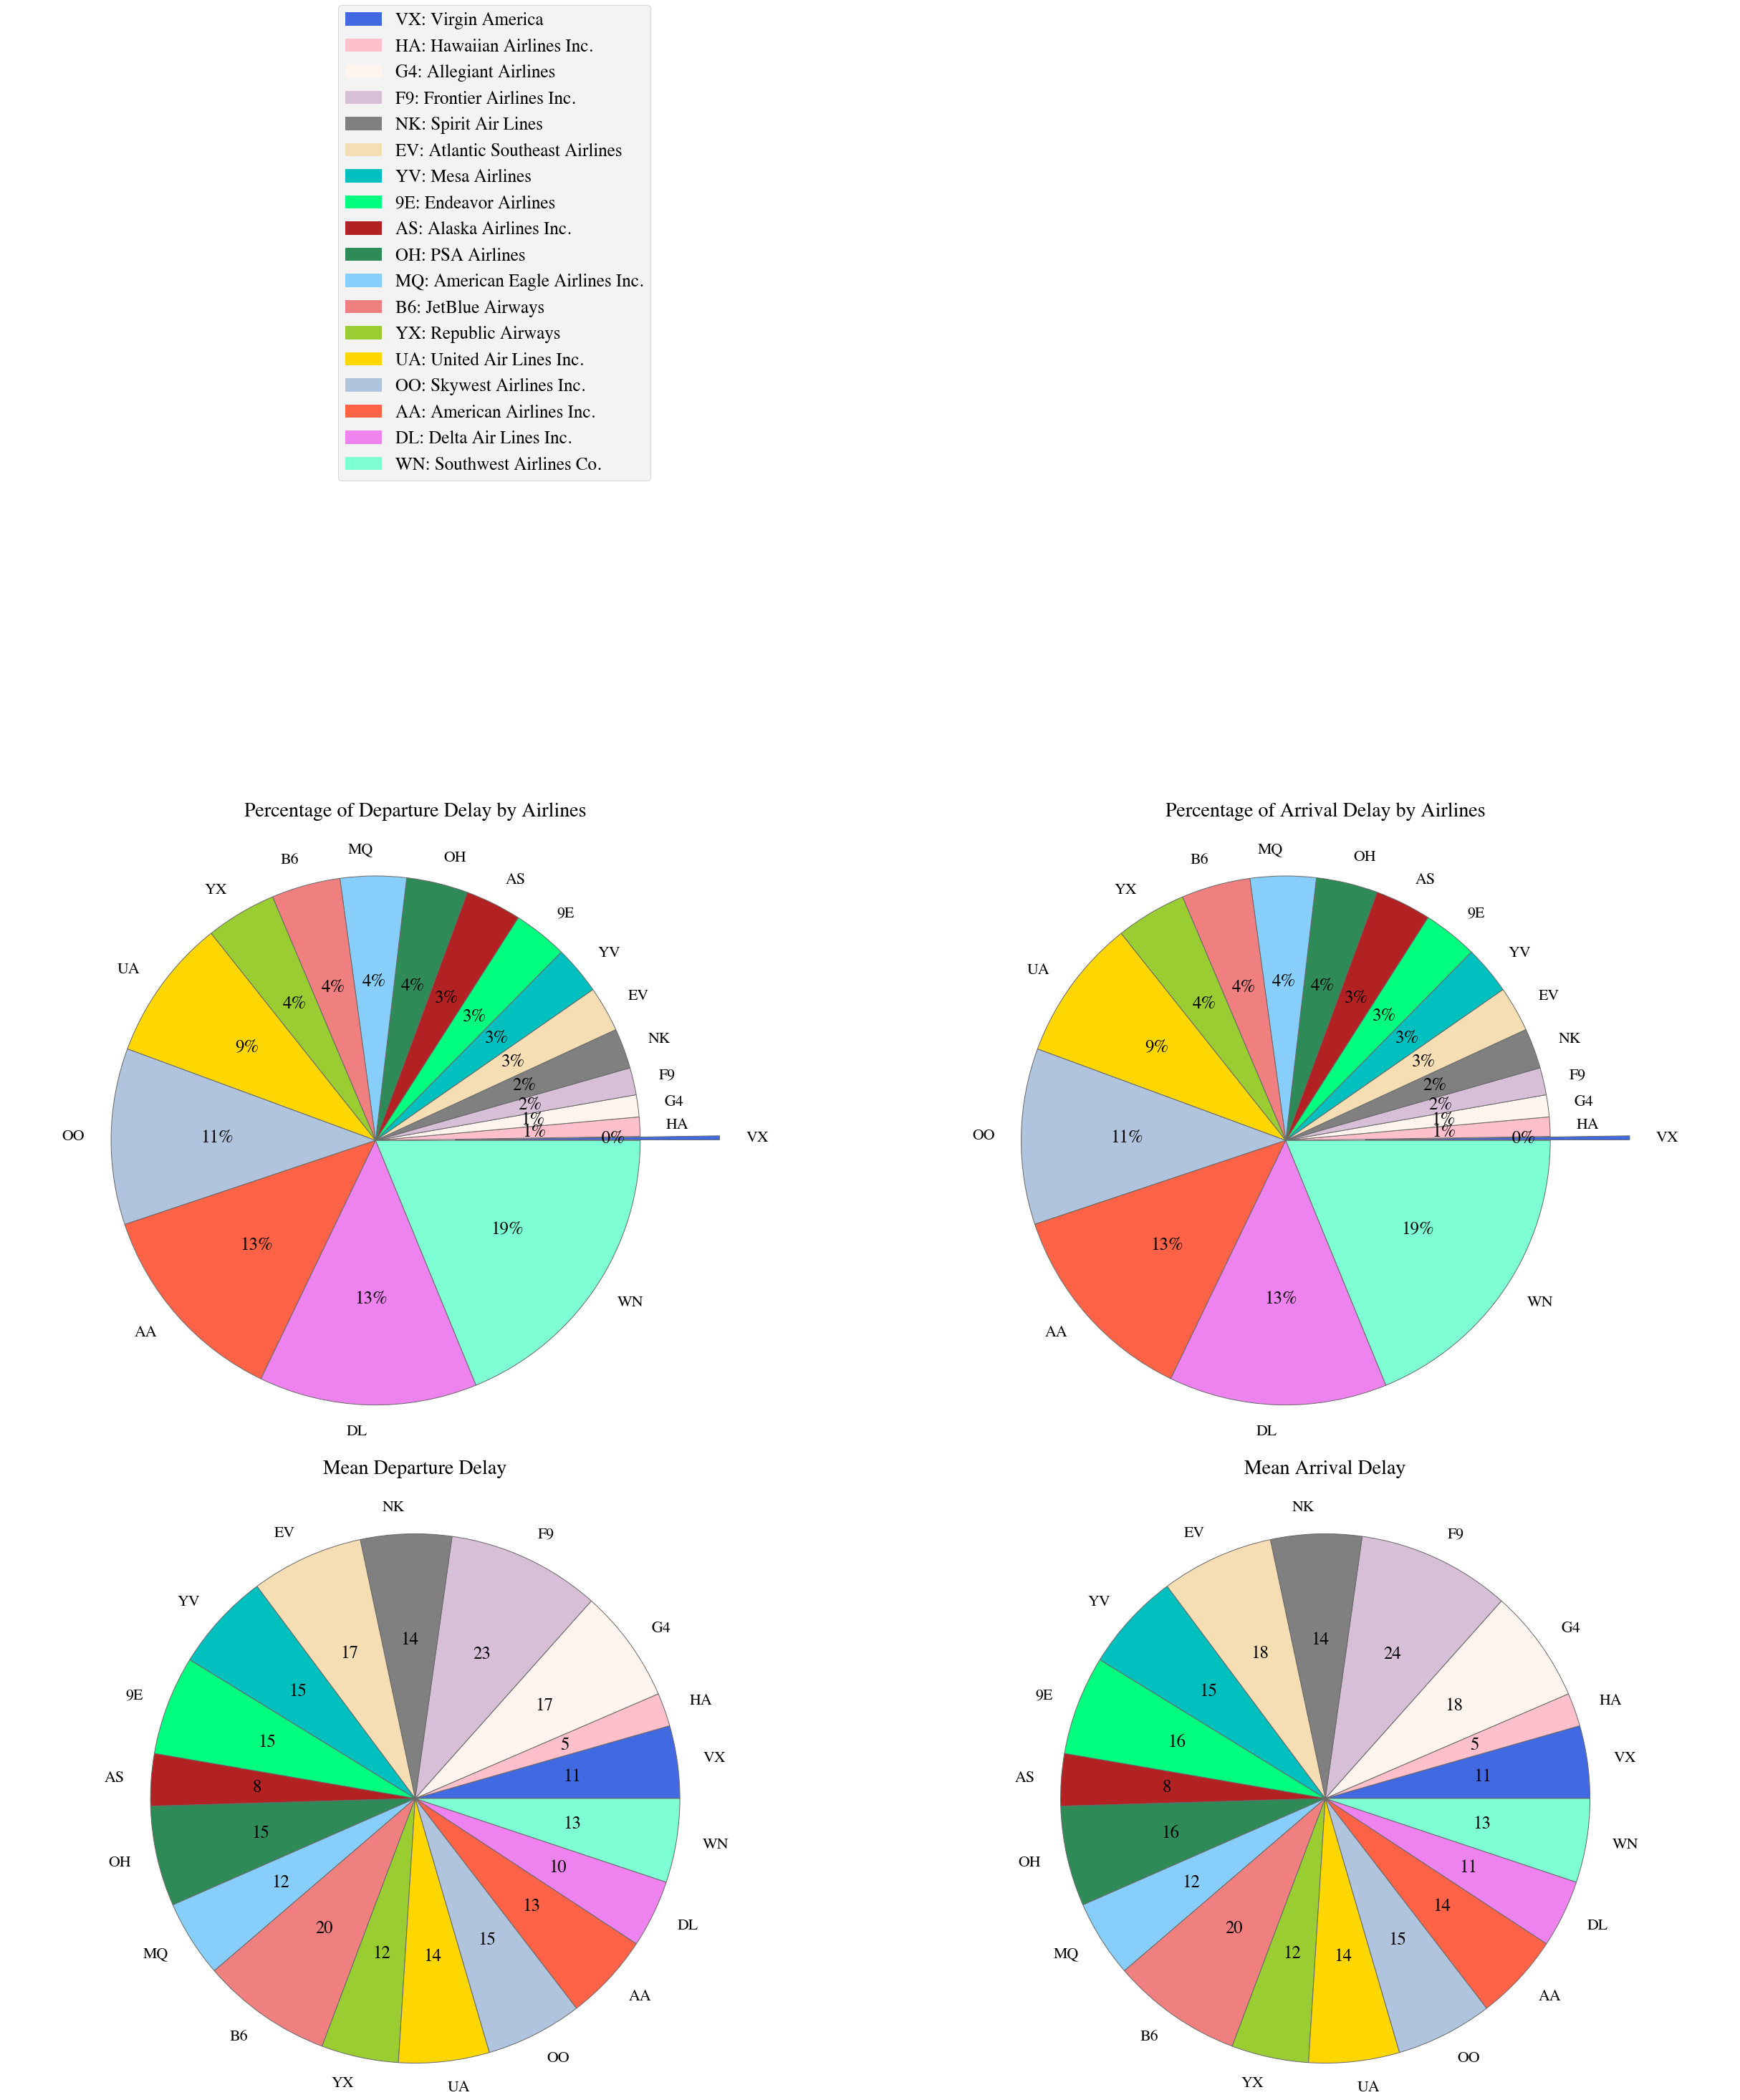

In [214]:
font = {'family':'Times', 'weight':'bold', 'size':25}
mpl.rc('font', **font)

sub_data = data.loc[:, ['CARRIER', 'DEP_DELAY', 'ARR_DELAY']]
sub_data['AIRLINE'] = sub_data['CARRIER'].replace(airlines_dict)

colors = ['royalblue', 'pink', 'seashell', 'thistle', 'grey', 'wheat', 'c', 'springgreen', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'lightsteelblue', 'tomato', 'violet', 'aquamarine', 'chartreuse']

fig = plt.figure(1, figsize=(35,35))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[1,0]) 
ax3=fig.add_subplot(gs[0,1]) 
ax4=fig.add_subplot(gs[1,1]) 

# % pie chart for departure delay
labels = [s for s in  stats.index]
sizes  = stats['count'].values
explode = [0.3 if sizes[i] < 30000 else 0.0 for i in range(len(airlines_dict))]
patches, texts, autotexts = ax1.pie(sizes, labels=labels, colors = colors, explode = explode, autopct='%1.0f%%', shadow=False, startangle=0)
for i in range(len(airlines_dict)): 
    texts[i].set_fontsize(22)
ax1.axis('equal')
ax1.set_title('Percentage of Departure Delay by Airlines', color = 'black',fontsize=28, y=1.05)

# legend
comp_handler = []
for i in range(len(airlines_dict)):
    lab = stats.index[i] + ': ' + airlines_dict[stats.index[i]]
    comp_handler.append(mpatches.Patch(color=colors[i], label = lab))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), fontsize = 25, bbox_transform=plt.gcf().transFigure)

# % pie chart for arrival delay
labels2 = [s for s in  stats2.index]
sizes2  = stats2['count'].values
explode2 = [0.3 if sizes[i] < 30000 else 0.0 for i in range(len(airlines_dict))]
patches, texts, autotexts = ax3.pie(sizes2, labels=labels2, colors = colors, explode = explode2, autopct='%1.0f%%', shadow=False, startangle=0)
for i in range(len(airlines_dict)): 
    texts[i].set_fontsize(22)
ax3.axis('equal')
ax3.set_title('Percentage of Arrival Delay by Airlines', color = 'black',fontsize=28, y=1.05)


# mean pie chart
sizes  = stats['mean'].values
sizes  = [max(s,0) for s in sizes]

patches, texts, autotexts = ax2.pie(sizes, labels = labels, colors = colors, shadow=False, startangle=0, autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(airlines_dict)): 
    texts[i].set_fontsize(22)
ax2.axis('equal')
ax2.set_title('Mean Departure Delay', color='black', fontsize=28, y=1.05)

sizes2  = stats2['mean'].values
sizes2  = [max(s,0) for s in sizes2]

patches, texts, autotexts = ax4.pie(sizes, labels = labels2, colors = colors, shadow=False, startangle=0, autopct = lambda p :  '{:.0f}'.format(p * sum(sizes2) / 100))
for i in range(len(airlines_dict)): 
    texts[i].set_fontsize(22)
ax4.axis('equal')
ax4.set_title('Mean Arrival Delay', color='black', fontsize=28, y=1.05)
plt.tight_layout(w_pad=3)


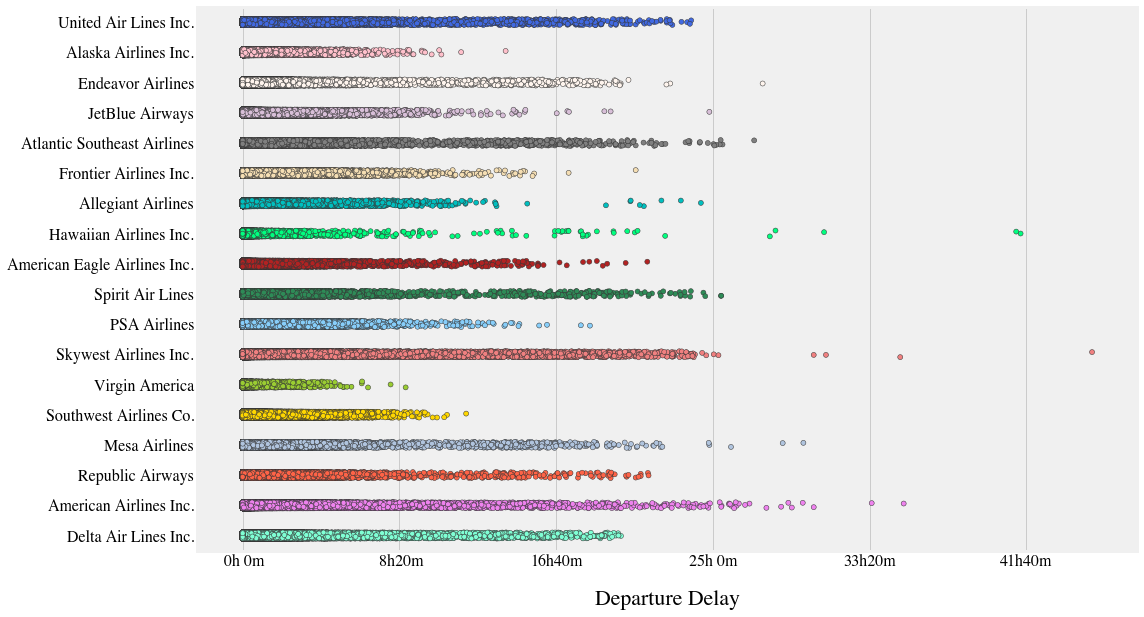

In [116]:
# Delay time mapping
colors = ['royalblue', 'pink', 'seashell', 'thistle', 'grey', 'wheat', 'c', 'springgreen', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'lightsteelblue', 'tomato', 'violet', 'aquamarine', 'chartreuse']

fig, ax5 = plt.subplots(figsize=(15, 10))
ax5 = sns.stripplot(y="AIRLINE", x="DEP_DELAY", size = 5, palette = colors, data=sub_data, linewidth = 0.5,  jitter=True)
plt.setp(ax5.get_xticklabels(), fontsize=16)
plt.setp(ax5.get_yticklabels(), fontsize=16)
ax5.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)]) for x in ax5.get_xticks()])
plt.xlabel('Departure Delay', fontsize=22,color='black', labelpad=20)
ax5.yaxis.label.set_visible(False)



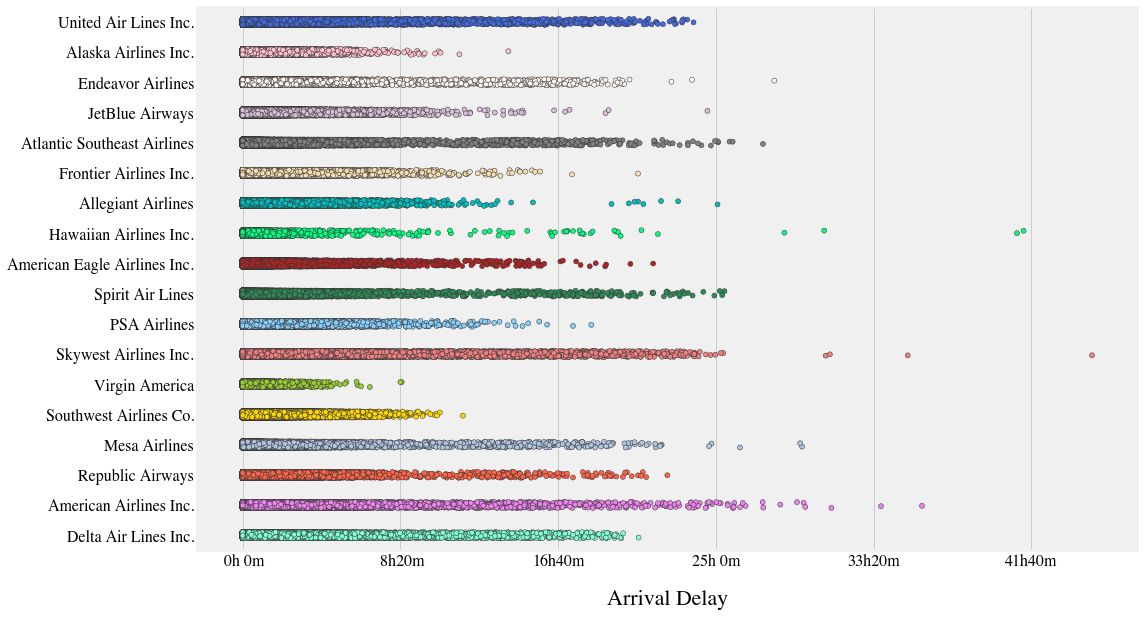

In [117]:

fig, ax6 = plt.subplots(figsize=(15, 10))
ax6 = sns.stripplot(y="AIRLINE", x="ARR_DELAY", size = 5, palette = colors, data=sub_data, linewidth = 0.5,  jitter=True)
plt.setp(ax6.get_xticklabels(), fontsize=16)
plt.setp(ax6.get_yticklabels(), fontsize=16)
ax6.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)]) for x in ax6.get_xticks()])
plt.xlabel('Arrival Delay', fontsize=22,color='black', labelpad=20)
ax6.yaxis.label.set_visible(False)


In [76]:
def create_sub(data, airline):
    temp_data = data[data['CARRIER'] == airline][['DEP_TIME','ORIGIN_AIRPORT','DEST_AIRPORT','ARR_DELAY']]
    temp_data['ARR_DELAY'] = temp_data['ARR_DELAY'].apply(lambda x:x if x < 1000 else np.nan)
    temp_data.dropna(how = 'any', inplace = True)
    timecalc = lambda x:int(x/100)*60+(x%100)
    temp_data['DEP_VALUE'] = temp_data['DEP_TIME'].apply(timecalc)
    ans = temp_data.groupby(['DEP_VALUE', 'ORIGIN_AIRPORT', 'DEST_AIRPORT'],as_index = False).mean()
    return ans

In [454]:
airline = 'YX'
new_data = create_sub(data, airline)
new_data

,DEP_VALUE,ORIGIN_AIRPORT,DEST_AIRPORT,DEP_TIME,ARR_DELAY
0,10,11057,11066,10,5.25
1,10,11057,12339,10,3.75
2,10,11057,12451,10,0.00
3,10,11057,14576,10,0.00
4,10,13930,15380,10,0.00
...,...,...,...,...,...
13505,1435,11292,10713,2355,8.00
13506,1435,11292,13851,2355,0.00
13507,1435,12266,11140,2355,0.00
13508,1435,12266,13158,2355,18.00


In [455]:
X = np.array(new_data[['ORIGIN_AIRPORT', 'DEP_VALUE', 'DEST_AIRPORT']])
Y = np.array(new_data['ARR_DELAY'])
Y = Y.reshape(len(Y), 1)

In [456]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [457]:
score_min = 10000
for pol_order in range(1, 3, 1):
    for alpha in range(2, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)

        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

n=1 alpha=0.2 , MSE = 567.1
n=1 alpha=0.4 , MSE = 567.56
n=1 alpha=0.6 , MSE = 568.23
n=1 alpha=0.8 , MSE = 568.95
n=1 alpha=1.0 , MSE = 569.65
n=1 alpha=1.2 , MSE = 570.31
n=1 alpha=1.4 , MSE = 570.91
n=1 alpha=1.6 , MSE = 571.46
n=1 alpha=1.8 , MSE = 571.96
n=2 alpha=0.2 , MSE = 567.06
n=2 alpha=0.4 , MSE = 566.98
n=2 alpha=0.6 , MSE = 566.97
n=2 alpha=0.8 , MSE = 567.02
n=2 alpha=1.0 , MSE = 567.11
n=2 alpha=1.2 , MSE = 567.23
n=2 alpha=1.4 , MSE = 567.38
n=2 alpha=1.6 , MSE = 567.54
n=2 alpha=1.8 , MSE = 567.71


In [458]:
ridgereg = Ridge(alpha = parameters[0]/10, normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)
print(score)

573.6916957228201


In [459]:
filename = airline.lower() + '_model.sav'
with open(filename, "wb") as f:
    pickle.dump((poly,ridgereg), f)
f.close()

In [453]:
test_data = pd.read_csv('sample.csv', low_memory=False)
test_data['DATE'] = pd.to_datetime(test_data['DATE'])
test_data


,DATE,CARRIER,CARRIER_ID,ORIGIN_AIRPORT,DEST_AIRPORT,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,CANCELLED,Unnamed: 10
0,2019-09-01,AA,19977,12892,12478,1010,35.0,1906,0.0,0.0,NaN
1,2019-09-01,DL,19977,12892,12478,1010,35.0,1906,0.0,0.0,NaN


In [336]:
testset = create_sub(test_data, airline)  
testset

,DEP_VALUE,ORIGIN_AIRPORT,DEST_AIRPORT,DEP_TIME,ARR_DELAY
0,610,12892,12478,1010,0.0


In [339]:
X_test = np.array(testset[['ORIGIN_AIRPORT', 'DEP_VALUE', 'DEST_AIRPORT']])
Y_test = np.array(testset['ARR_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [340]:
print(X_test)
result = ridgereg.predict(poly.fit_transform(X_test))
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))
'Expected Flight Delay is {:.2f} minutes'.format(np.sqrt(score))

[[   50   610 12478]]
MSE = 134.51


'Expected Flight Delay is 11.60 minutes'

In [343]:
# airline 
airports = pd.read_csv('airport_id.csv')
airports['AIRPORT_ID'] = airports['AIRPORT_ID']
airports_dict = airports.set_index('AIRPORT')['AIRPORT_ID'].to_dict()

In [345]:
def test_input(airline, depart_airport, arrive_airport, dep_at):
    dep_val = int(dep_at/100)*60+(dep_at%100)
    user_input = [[dep_val, airports_dict[depart_airport], airports_dict[arrive_airport], dep_at]]
    df = pd.DataFrame(user_input, columns = ['DEP_VALUE', 'ORIGIN_AIRPORT', 'DEST_AIRPORT', 'DEP_TIME']) 
    X = np.array(testset[['ORIGIN_AIRPORT', 'DEP_VALUE', 'DEST_AIRPORT']])
    filename = airline.lower() + '_model.sav'
    return X, filename

In [346]:
airline = 'AA'
depart_airport = 'ATL'
arrive_airport = 'SEA'
dep_at = int(830)

test_data, filename = test_input(airline, depart_airport, arrive_airport, dep_at) 
print(test_data)

[[   50   610 12478]]


In [347]:
with open(filename, "rb") as f:
    print(f)
    loaded_poly,loaded_ridge = pickle.load(f) 
f.close()
print(loaded_poly)
print(loaded_ridge)

<_io.BufferedReader name='aa_model.sav'>
PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')
Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)


In [348]:
new_x = loaded_poly.fit_transform(test_data)
score = loaded_ridge.predict(new_x)[0][0]

'Expected Flight Delay is {:.2f} minutes'.format(np.sqrt(score))

'Expected Flight Delay is 3.41 minutes'